[*********************100%***********************]  1 of 1 completed
C:\Users\Michał\Desktop\crypto\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Michał\Desktop\crypto\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Michał\Desktop\crypto\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


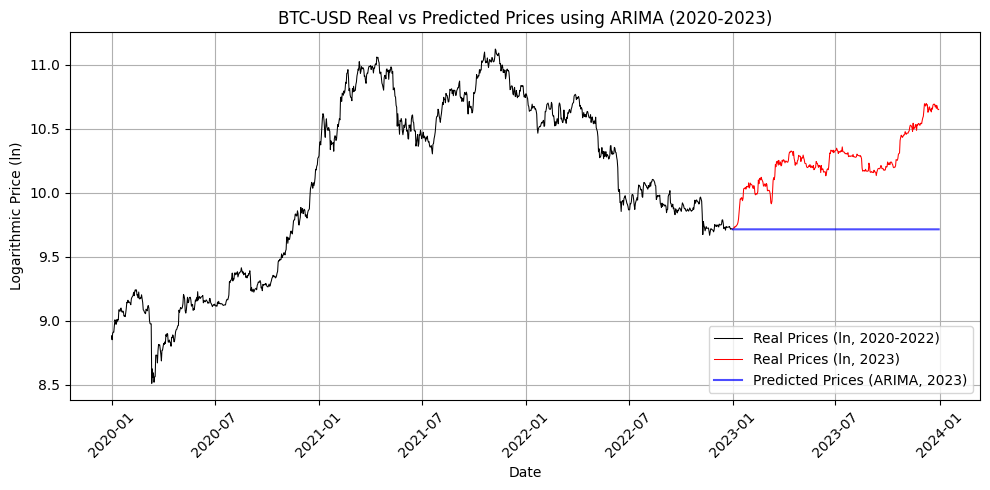

Mean Squared Error: 185135010.60177192


In [5]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Funkcja pobierająca dane z yfinance
def get_crypto_data(symbol, start_date, end_date):
    crypto_data = yf.download(symbol, start=start_date, end=end_date)
    return crypto_data

# Pobieranie danych o kryptowalutach
crypto_symbol = "BTC-USD"  # Symbol kryptowaluty
start_date = "2020-01-01"
end_date = "2023-12-31"  # Pobranie danych do końca 2023

data = get_crypto_data(crypto_symbol, start_date, end_date)

# Podzielenie danych na okres nauki (2020-2022) i okres testowy (2023)
train_data = data.loc['2020-01-01':'2022-12-31']['Close']  # Dane treningowe (ceny zamknięcia)
test_data = data.loc['2023-01-01':'2023-12-31']['Close']   # Dane testowe (ceny zamknięcia)

# Tworzenie modelu ARIMA na podstawie danych treningowych
# Parametry modelu ARIMA (p, d, q):
p = 4  # Liczba opóźnień
d = 1  # Różnicowanie w celu stacjonarności
q = 0  # Waga ruchomej średniej

model = ARIMA(train_data, order=(p, d, q))
fitted_model = model.fit()

# Prognozowanie na podstawie modelu
forecast = fitted_model.forecast(steps=len(test_data))

# Wykres rzeczywistych cen i prognozowanych na 2023 rok
plt.figure(figsize=(10, 5))

# Wykres rzeczywistych danych (2020-2022)
plt.plot(train_data.index, np.log(train_data), label='Real Prices (ln, 2020-2022)', color='black', linewidth=0.75)

# Wykres rzeczywistych danych (2023)
plt.plot(test_data.index, np.log(test_data), label='Real Prices (ln, 2023)', color='red', linewidth=0.75)

# Wykres przewidywanych cen (na 2023)
plt.plot(test_data.index, np.log(forecast), label='Predicted Prices (ARIMA, 2023)', color='blue', alpha=0.7)

plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Logarithmic Price (ln)')
plt.title(f'{crypto_symbol} Real vs Predicted Prices using ARIMA (2020-2023)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Wyświetlanie błędu prognozy
mse = mean_squared_error(test_data, forecast)
print(f'Mean Squared Error: {mse}')
